In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import re

url = 'https://raw.githubusercontent.com/umaimehm/Intro_to_AI_2021/main/assignment1/Ruter_data.csv'
df = pd.read_csv(url, sep=';')

Text(0, 0.5, 'Antall Bussplasser')

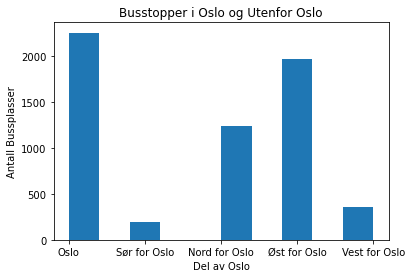

In [2]:
# Grouping Oslo-kommuner togheter
df['Kommune'] = df['Kommune'].replace(['Gamle Oslo', 'Bærum','Alna','Bjerke','Stovner','Vestre Aker','Grünerløkka','Nordstrand','Ullern','Grorud','Sentrum','St.Hanshaugen','Sagene','Frogner','Søndre Nordstrand','Nordre Aker'],'Oslo')
df['Kommune'] = df['Kommune'].replace(['Lillestrøm', 'Lørenskog','Rælingen','Aurskog-Høland'],'Øst for Oslo')
df['Kommune'] = df['Kommune'].replace(['Asker','Lier','Nordmarka','Drammen'],'Vest for Oslo')
df['Kommune'] = df['Kommune'].replace(['Ullensaker','Nittedal','Nannestad','Eidsvoll','Nes','Gjerdrum','Hurdal'],'Nord for Oslo')
df['Kommune'] = df['Kommune'].replace(['Enebakk','Nordre Follo','Indre Østfold'],'Sør for Oslo')

# Create figure
fig, ax = plt.subplots()
ax.hist(df['Kommune'])
# set title and labels
ax.set_title('Busstopper i Oslo og Utenfor Oslo')
ax.set_xlabel('Del av Oslo')
ax.set_ylabel('Antall Bussplasser')

In [3]:
delay = df.rename(columns={'Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra': 'True_Arrival', 'Tidspunkt_Faktisk_Avgang_Holdeplass_Fra': 'True_Depature','Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra': 'Planned_Arrival', 'Tidspunkt_Planlagt_Avgang_Holdeplass_Fra': 'Planned_Depature'})

In [4]:
delay = delay.filter(items=['True_Arrival','Planned_Arrival'])
delay = delay[delay.True_Arrival != ':']
delay[['True_Hours','True_Minutes','True_Seconds']] = delay['True_Arrival'].str.split(':',expand=True)
delay[['Planned_Hours','Planned_Minutes','Planned_Seconds']] = delay['Planned_Arrival'].str.split(':',expand=True)

In [5]:
delay["Planned_Hours"] = pd.to_numeric(delay["Planned_Hours"])
delay["Planned_Hours"] = delay["Planned_Hours"].mod(24)
delay["True_Hours"] = pd.to_numeric(delay["True_Hours"])
delay["True_Hours"] = delay["True_Hours"].mod(24)

In [6]:
colons = ['True_Hours','True_Minutes', 'True_Seconds']
delay['True_Arrival'] = delay[colons].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
colons = ['Planned_Hours','Planned_Minutes', 'Planned_Seconds']
delay['Planned_Arrival'] = delay[colons].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
delay = delay.filter(items=['True_Arrival','Planned_Arrival', 'Planned_Hours'])
delay = delay.rename(columns={'Planned_Hours': 'Timer'})

In [7]:
delay["True_Arrival"] = delay["True_Arrival"].astype("datetime64")
delay["Planned_Arrival"] = delay["Planned_Arrival"].astype("datetime64")
delay['Difference'] = (delay.True_Arrival - delay.Planned_Arrival)
delay['Difference'] = delay['Difference'].dt.total_seconds()
delay = delay.filter(items=['Timer','Difference'])
data = delay.groupby(delay['Timer']).mean()

In [8]:
threshold_max = delay["Difference"].quantile(0.99)
threshold_min = delay["Difference"].quantile(0.01)
ruterDataDag = delay[(delay["Difference"] < threshold_max) & (delay["Difference"] > threshold_min) & (delay['Timer'] >= 6)]
ruterDataNatt = delay[(delay["Difference"] < threshold_max) & (delay["Difference"] > threshold_min) & (delay['Timer'] <= 5)]

Text(0, 0.5, 'Delay in seconds')

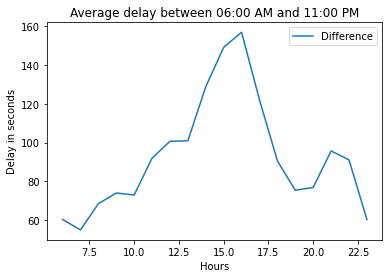

In [9]:
ruterDataDag = ruterDataDag.groupby(ruterDataDag.Timer).mean()
forsinkelseGrafDag = ruterDataDag.plot.line(title="Average delay between 06:00 AM and 11:00 PM")
forsinkelseGrafDag.set_xlabel("Hours")
forsinkelseGrafDag.set_ylabel("Delay in seconds")